In [1]:
# Libs
import numpy as np
import matplotlib.pyplot as plt

### Synthetic World with treasures/pirates/ obstacles

In [15]:
# world parameters
length, width = 200, 9
jump_length = 2

# probabilities of treasures, pirates, obstacles in percent:
rate_treasures, rate_pirates, rate_obstacles = .05, .05, .05

# create grid 
grid = np.zeros((length, width+2*jump_length))
for i in range(jump_length):
    grid[:,i] = grid[:,width+jump_length+i] = -1

# generate treasures, pirates and obstacles using MC sampling.
mc_samplings = [np.random.rand(length, width), np.random.rand(length, width), np.random.rand(length, width)]
rates = [rate_treasures, rate_pirates, rate_obstacles]
for i in range(length):
    for j in range(width):
        mc_sampls = [mc_samplings[0][i,j], mc_samplings[1][i,j], mc_samplings[2][i,j]]
        id = np.argmin(mc_sampls)
        if mc_sampls[id] <= rates[id]:
            if id == 0:
                grid[i, j+jump_length] = 1 # treasures
            elif id == 1:
                grid[i, j+jump_length] = 2 # pirates
            elif id == 2:
                grid[i, j+jump_length] = -1

In [16]:
START = (-1, 4)

In [17]:
grid

array([[-1., -1.,  0., ...,  0., -1., -1.],
       [-1., -1.,  2., ...,  0., -1., -1.],
       [-1., -1.,  0., ...,  0., -1., -1.],
       ...,
       [-1., -1.,  0., ...,  0., -1., -1.],
       [-1., -1.,  0., ...,  0., -1., -1.],
       [-1., -1.,  0., ...,  2., -1., -1.]])

### Random paths

In [18]:
def next_possible_state(coord, grid, w=1):
    i, j = coord
    i = i+1
    if i > grid.shape[0]:
        return -1
    else:
        next_states = list(map(lambda x: (i, x), 
                           list(filter(lambda x: (width > x > -1) and (grid[i, x] != -1), range(j-w, j+w)))))
        if len(next_states) != 0:
            return next_states
        else:
            print('WARNING: No Path Possible to the right!')
            print('WARNING: contiguous ostacles recreate World')
            return 'No Path Possible to the right!'

def random_move(coord, grid, w=1):
    possible_coords = next_possible_state(coord, grid, w)
    return possible_coords[np.random.choice([i for i in range(len(possible_coords))])]

def generate_random_path(jump_dist = 2):
    random_path = []
    for i in range(length):
        if len(random_path) == 0:
            random_path.append(random_move(START, grid, jump_dist))
        else:
            random_path.append(random_move(random_path[-1], grid, jump_dist))
    return random_path

In [19]:
random_path = generate_random_path()

### Grid Search

In [20]:
def cost_function(coords, grid, reward_treasure=10, cost_pirates=-100):
    """   """
    score = 0.
    for i, j in coords:
        if grid[i,j] == 2:
            score += cost_pirates
        elif grid[i,j] == 1:
            score += reward_treasure
    return score

In [21]:
def recu_search(coords, grid, depth_max=1, w=2):
    coord = coords[-1]
    possible_coords = next_possible_state(coord, grid, w)
    possible_coords = [coords+[c] for c in possible_coords]
    if len(coords) > depth_max:
        my_search = []
        [my_search.append(c) for c in possible_coords]
        return my_search
    else:
        my_search = []
        [[my_search.append(c) for c in recu_search(pc, grid, depth_max)]
          for pc in possible_coords]
        return my_search

def select_best_coords(coords, grid):
    evaluations = [cost_function(cs, grid) for cs in coords]
    idx = np.argmax(evaluations) if len(set(evaluations)) != 1 else np.random.choice(list(range(len(evaluations))))
    return coords[idx]

In [22]:
def generate_grid_search(DEPTH = 3):
    grid_search_path_d = []

    while len(grid_search_path_d) < length:
        if len(grid_search_path_d) == 0:
            coords = recu_search([START], grid[:,jump_length:-jump_length], DEPTH)
            coord = select_best_coords(coords, grid[:,jump_length:-jump_length])
            grid_search_path_d += coord
        else:
            coord = grid_search_path_d[-1]
            coords = recu_search([grid_search_path_d[-1]], grid[:,jump_length:-jump_length], 
                                 min(DEPTH, length-len(grid_search_path_d)))
            coord = select_best_coords(coords, grid[:,jump_length:-jump_length])
            grid_search_path_d += coord[1:]
    return grid_search_path_d

### Building the grid search, might take some time!

In [23]:
grid_search_path_d1 = generate_grid_search(1)
grid_search_path_d3 = generate_grid_search(3)
grid_search_path_d7 = generate_grid_search(7)
grid_search_path_d10 = generate_grid_search(10)

### Plot

In [26]:
data_treasures, data_pirates, data_obstacles = [], [], []
for i in range(length):
    for j in range(width):
        v = grid[:, jump_length:-jump_length][i, j] # grid[i, j]
        if v != 0:
            if v == 1:
                data_treasures.append((i, j))
            elif v == 2:
                data_pirates.append((i, j))
            elif v == -1:
                data_obstacles.append((i, j))

### The deeper the grid search the better the score

path reward random:  -400.0
path brute force grid search d=1:  360.0
path brute force grid search d=3:  420.0
path brute force grid search d=7:  510.0
path brute force grid search d=10:  550.0


Text(0.5,1,'Wandling in synthetic World: simulation')

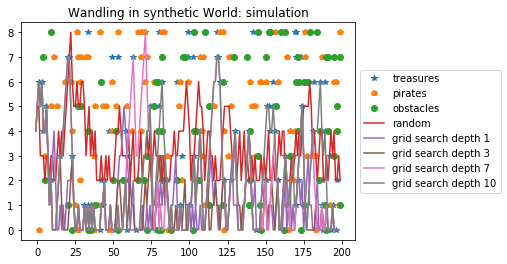

In [27]:
plt.plot(list(map(lambda x: x[0], data_treasures)), list(map(lambda x: x[1], data_treasures)), '*', label='treasures')
plt.plot(list(map(lambda x: x[0], data_pirates)), list(map(lambda x: x[1], data_pirates)), 'p', label='pirates')
plt.plot(list(map(lambda x: x[0], data_obstacles)), list(map(lambda x: x[1], data_obstacles)), 'o', label='obstacles')

plt.plot(list(map(lambda x: random_path[x][0], range(length))),
         list(map(lambda x: random_path[x][1], range(length))), label='random')

plt.plot(list(map(lambda x: grid_search_path_d1[x][0], range(length))),
         list(map(lambda x: grid_search_path_d1[x][1], range(length))), label='grid search depth 1')

plt.plot(list(map(lambda x: grid_search_path_d3[x][0], range(length))),
         list(map(lambda x: grid_search_path_d3[x][1], range(length))), label='grid search depth 3')

plt.plot(list(map(lambda x: grid_search_path_d7[x][0], range(length))),
         list(map(lambda x: grid_search_path_d7[x][1], range(length))), label='grid search depth 7')

plt.plot(list(map(lambda x: grid_search_path_d10[x][0], range(length))),
         list(map(lambda x: grid_search_path_d10[x][1], range(length))), label='grid search depth 10')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

print('path reward random: ', cost_function(random_path, grid[:, jump_length:-jump_length]))
print('path brute force grid search d=1: ', cost_function(grid_search_path_d1, grid[:, jump_length:-jump_length]))
print('path brute force grid search d=3: ', cost_function(grid_search_path_d3, grid[:, jump_length:-jump_length]))
print('path brute force grid search d=7: ', cost_function(grid_search_path_d7, grid[:, jump_length:-jump_length]))
print('path brute force grid search d=10: ', cost_function(grid_search_path_d10, grid[:, jump_length:-jump_length]))

plt.title('Wandling in synthetic World: simulation')